# Emotion Detection Model
## Imports
This section contains the necessary imports for the Jupyter notebook.

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Data Pre-processing
The data for this model can be found [here](https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer). Once the data has been imported we define the `load_and_flatten` function which loads images from a directory, converts them to greyscale, resizes it to 48x48 pixels and stores it into a 1 dimensional array. This is done to prepare the image for our K Means Cluster model. Once all images have been processed we

In [9]:
def load_and_flatten(directory):
    images = []
    labels = []
    for emotion in os.listdir(directory):
        emotion_dir = os.path.join(directory, emotion)
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                img = cv2.resize(img, (48, 48))              # Resize to 48x48
                images.append(img.flatten())                 # Flatten to 1D array
                labels.append(emotion)                       # Original string labels
    return np.array(images), np.array(labels)

# Load both datasets
X_train, Y_train = load_and_flatten("train")
X_test, Y_test = load_and_flatten("test")

# --- Preprocessing ---
# Normalize both datasets to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Encode emotion labels to integers
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)  # Use same encoder as training

## Model Fitting

In [10]:
# --- K-means Clustering ---
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans.fit(X_train)

# --- Cluster-to-Emotion Mapping (Using Training Data) ---
train_clusters = kmeans.labels_
df = pd.DataFrame({'cluster': train_clusters, 'emotion': Y_train_encoded})
cluster_to_emotion = {}

for cluster in range(7):
    cluster_emotions = df[df['cluster'] == cluster]['emotion']
    if len(cluster_emotions) == 0:
        cluster_to_emotion[cluster] = -1
    else:
        most_common = mode(cluster_emotions, keepdims=False).mode
        cluster_to_emotion[cluster] = most_common

## Predictions

Accuracy: 0.25

Confusion Matrix:
[[   0    0    0  833    0  125    0]
 [   0    0    0  106    0    5    0]
 [   0    0    0  923    0  101    0]
 [   0    0    0 1553    0  221    0]
 [   0    0    0 1036    0  197    0]
 [   0    0    0 1000    0  247    0]
 [   0    0    0  798    0   33    0]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.00      0.00      0.00      1024
       happy       0.25      0.88      0.39      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.27      0.20      0.23      1247
   surprised       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.07      0.15      0.09      7178
weighted avg       0.11      0.25      0.14      7178



/home/adamfitz395/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adamfitz395/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adamfitz395/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


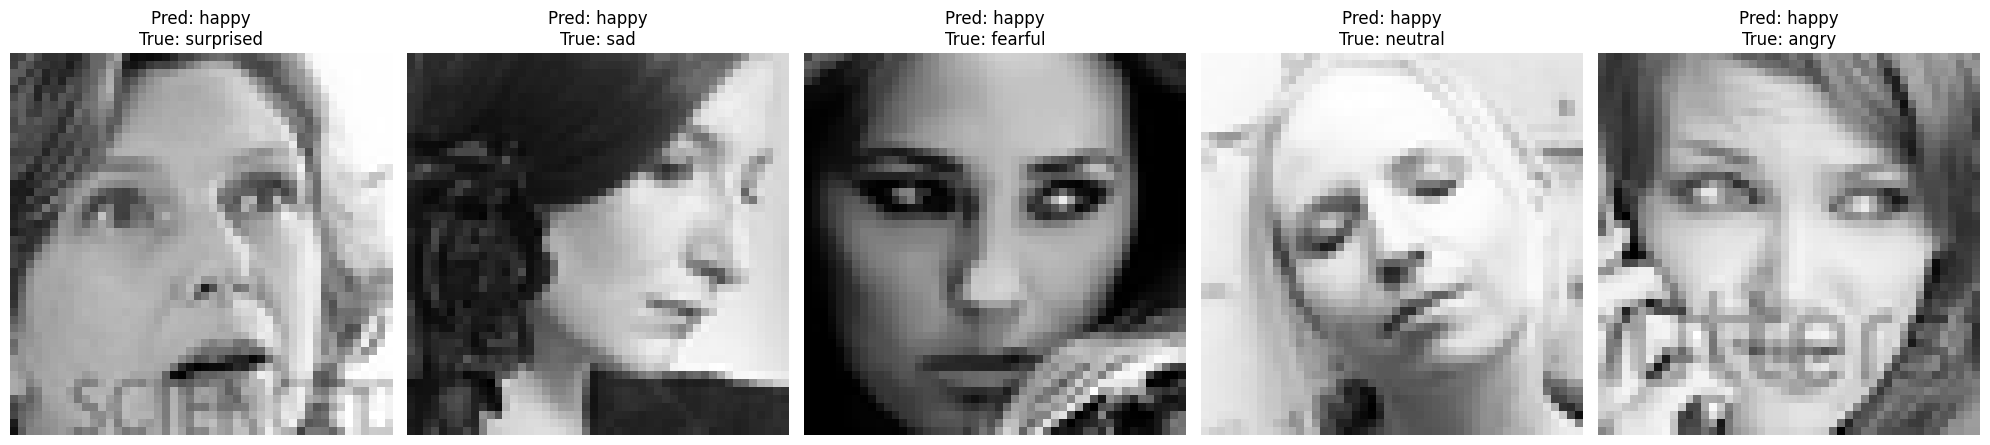

In [12]:
test_clusters = kmeans.predict(X_test)

# Map clusters to emotions using our training-derived mapping
predicted_emotions = np.array([cluster_to_emotion[c] for c in test_clusters])

# Decode back to original emotion strings
predicted_emotion_labels = label_encoder.inverse_transform(predicted_emotions)

# --- Evaluation ---
print(f"Accuracy: {accuracy_score(Y_test, predicted_emotion_labels):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, predicted_emotion_labels))
print("\nClassification Report:")
print(classification_report(Y_test, predicted_emotion_labels))

# --- Visualization ---
# Plot test samples with predictions
n_samples = 5
plt.figure(figsize=(20, 8))
for i in range(n_samples):
    idx = np.random.randint(len(X_test))
    plt.subplot(1, n_samples, i+1)
    plt.imshow(X_test[idx].reshape(48, 48), cmap='gray')
    plt.title(f"Pred: {predicted_emotion_labels[idx]}\nTrue: {Y_test[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()